In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator

In [2]:
raw = pd.read_csv('./data/tr_eikon_eod_data.csv', 
                  index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [3]:
selected = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [4]:
# data preparation
data = pd.DataFrame(raw[selected].dropna())
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67
2010-01-08,30.282827,30.660,20.83,133.52,174.31
...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54
2018-06-26,184.430000,99.080,49.67,1691.09,221.58
2018-06-27,184.160000,97.540,48.76,1660.51,220.18


In [5]:
# data pre-processing
# generate log returns for each stock
for stock in selected:
    data['Returns_' + stock] = np.log(data[stock] / data[stock].shift(1)).dropna()
    data['Returns_' + stock].fillna(0, inplace=True)
data

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_16953/2098642776.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Returns_' + stock].fillna(0, inplace=True)
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_16953/2098642776.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,Returns_AAPL.O,Returns_MSFT.O,Returns_INTC.O,Returns_AMZN.O,Returns_GS.N
Date,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,30.625684,30.960,20.87,134.69,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525
2010-01-06,30.138541,30.770,20.80,132.25,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731
2010-01-07,30.082827,30.452,20.60,130.00,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379
2010-01-08,30.282827,30.660,20.83,133.52,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093
...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020
2018-06-26,184.430000,99.080,49.67,1691.09,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181
2018-06-27,184.160000,97.540,48.76,1660.51,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338


In [6]:
# generate direction of the stock price movements for each stock
for stock in selected:
    data['direction_' + stock] = np.sign(data['Returns_' + stock]).dropna().astype(int)
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,Returns_AAPL.O,Returns_MSFT.O,Returns_INTC.O,Returns_AMZN.O,Returns_GS.N,direction_AAPL.O,direction_MSFT.O,direction_INTC.O,direction_AMZN.O,direction_GS.N
Date,,,,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0
2010-01-05,30.625684,30.960,20.87,134.69,176.14,0.001727,0.000323,-0.000479,0.005883,0.017525,1,1,-1,1,1
2010-01-06,30.138541,30.770,20.80,132.25,174.26,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,-1,-1,-1,-1,-1
2010-01-07,30.082827,30.452,20.60,130.00,177.67,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,-1,-1,-1,-1,1
2010-01-08,30.282827,30.660,20.83,133.52,174.31,0.006626,0.006807,0.011103,0.026717,-0.019093,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,-1,-1,-1,-1,-1
2018-06-26,184.430000,99.080,49.67,1691.09,221.58,0.012330,0.006988,-0.020722,0.016660,0.000181,1,1,-1,1,1
2018-06-27,184.160000,97.540,48.76,1660.51,220.18,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,-1,-1,-1,-1,-1


In [7]:
# train-test split
split = int(len(data)*0.8)
data_train = data.iloc[:split].copy()
data_test = data.iloc[split:].copy()

In [8]:
# training hmm model, using 2 hidden states
def train_hmm(data, n_iter=50):
    best_model = None
    best_score = float('-inf')
    
    for _ in range(n_iter):
        model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
        model.fit(data)
        score = model.score(data)
        if score > best_score:
            best_score = score
            best_model = model
    
    return best_model

In [9]:
# generate trade signals
# rationale: if the hidden state with the highest mean is the first state, we go long, otherwise we go short
def generate_trading_signals(hidden_states, model):
    signals = np.zeros(len(hidden_states))
    for i in range(1, len(hidden_states)):
        if model.means_[hidden_states[i]] == model.means_.max():
            signals[i] = 1
        else:
            signals[i] = -1
    return signals

In [10]:
# display relevant columns in the dataset
data_train.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Returns_AAPL.O',
       'Returns_MSFT.O', 'Returns_INTC.O', 'Returns_AMZN.O', 'Returns_GS.N',
       'direction_AAPL.O', 'direction_MSFT.O', 'direction_INTC.O',
       'direction_AMZN.O', 'direction_GS.N'],
      dtype='object')

--Training--


Model is not converging.  Current: 4689.113477923709 is not greater than 4689.126057854265. Delta is -0.012579930556057661
Model is not converging.  Current: 4690.760165888485 is not greater than 4690.858040831091. Delta is -0.09787494260581298
Model is not converging.  Current: 4689.235928563576 is not greater than 4689.288233648118. Delta is -0.052305084542240365


Returns_AAPL.O         3.844918
Returns_HMM_AAPL.O    14.101106
dtype: float64
--Testing--
Returns_AAPL.O        1.574734
Returns_HMM_AAPL.O    1.517062
dtype: float64


Model is not converging.  Current: 4935.84810022901 is not greater than 4935.854724120536. Delta is -0.006623891526032821


--Training--


Model is not converging.  Current: 4936.796984080615 is not greater than 4936.804174551513. Delta is -0.007190470897512569
Model is not converging.  Current: 4935.871402710697 is not greater than 4935.887130715657. Delta is -0.015728004959782993
Model is not converging.  Current: 4935.790582094393 is not greater than 4935.796854832553. Delta is -0.006272738160078006
Model is not converging.  Current: 4935.506489529177 is not greater than 4935.56497278787. Delta is -0.05848325869283144
Model is not converging.  Current: 4935.8703306908255 is not greater than 4935.88956104688. Delta is -0.01923035605432233
Model is not converging.  Current: 4935.336377784777 is not greater than 4935.339469266697. Delta is -0.003091481919909711
Model is not converging.  Current: 4936.1640521656855 is not greater than 4936.184612550256. Delta is -0.020560384570671886
Model is not converging.  Current: 4935.65476592502 is not greater than 4935.6634015877835. Delta is -0.008635662763481378
Model is not conve

Returns_MSFT.O        1.848788
Returns_HMM_MSFT.O    2.662761
dtype: float64
--Testing--
Returns_MSFT.O        1.723348
Returns_HMM_MSFT.O    1.833671
dtype: float64
--Training--


Model is not converging.  Current: 4855.8916156291125 is not greater than 4855.905824879747. Delta is -0.014209250634849013
Model is not converging.  Current: 4833.204320152438 is not greater than 4833.21223273392. Delta is -0.007912581481832603
Model is not converging.  Current: 4795.451844308728 is not greater than 4795.454070207532. Delta is -0.0022258988037719973
Model is not converging.  Current: 4856.794036762265 is not greater than 4856.879344262376. Delta is -0.08530750011141208
Model is not converging.  Current: 4859.547548073056 is not greater than 4859.704646498202. Delta is -0.15709842514661432


Returns_INTC.O        1.785920
Returns_HMM_INTC.O    6.261909
dtype: float64
--Testing--
Returns_INTC.O        1.333065
Returns_HMM_INTC.O    0.953764
dtype: float64
--Training--


Model is not converging.  Current: 4418.542477994689 is not greater than 4418.547693858928. Delta is -0.005215864239289658
Model is not converging.  Current: 4418.884587893328 is not greater than 4418.9079047826335. Delta is -0.02331688930553355
Model is not converging.  Current: 4418.903712749954 is not greater than 4418.921171143098. Delta is -0.01745839314389741
Model is not converging.  Current: 4418.412261720291 is not greater than 4418.4142749261655. Delta is -0.002013205874391133


Returns_AMZN.O        6.071322
Returns_HMM_AMZN.O    7.624140
dtype: float64
--Testing--
Returns_AMZN.O        2.090903
Returns_HMM_AMZN.O    2.637601
dtype: float64
--Training--


Model is not converging.  Current: 4690.6308824876605 is not greater than 4690.659526792227. Delta is -0.028644304566114442
Model is not converging.  Current: 4690.5997181593875 is not greater than 4690.6499615174935. Delta is -0.050243358105944935
Model is not converging.  Current: 4690.487552667271 is not greater than 4690.491838969216. Delta is -0.004286301944375737
Model is not converging.  Current: 4690.596852378884 is not greater than 4690.652553385365. Delta is -0.055701006480376236
Model is not converging.  Current: 4690.632454217727 is not greater than 4690.669878097945. Delta is -0.03742388021782972
Model is not converging.  Current: 4690.510886976642 is not greater than 4690.531344690977. Delta is -0.02045771433495247
Model is not converging.  Current: 4690.621276777695 is not greater than 4690.660322055395. Delta is -0.03904527770009736
Model is not converging.  Current: 4690.633143876498 is not greater than 4690.639823333411. Delta is -0.006679456912934256
Model is not con

Returns_GS.N        0.976427
Returns_HMM_GS.N    4.767952
dtype: float64
--Testing--
Returns_GS.N        1.305148
Returns_HMM_GS.N    1.196733
dtype: float64


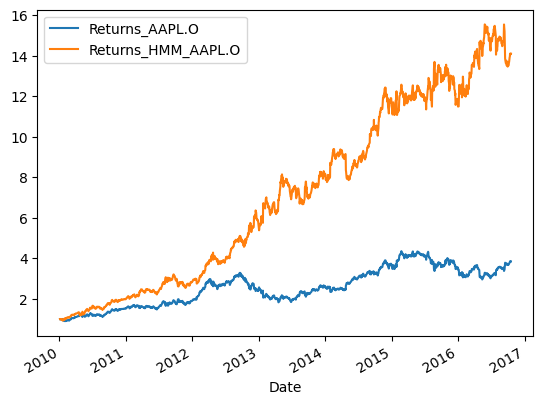

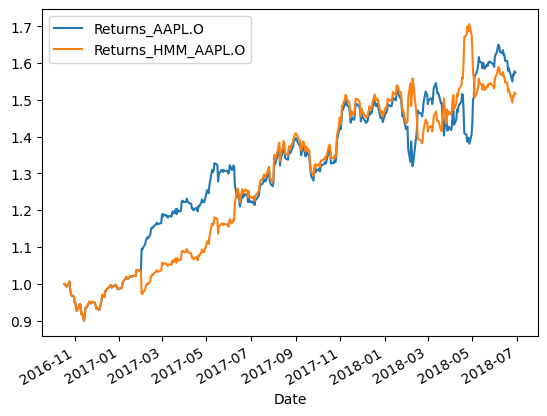

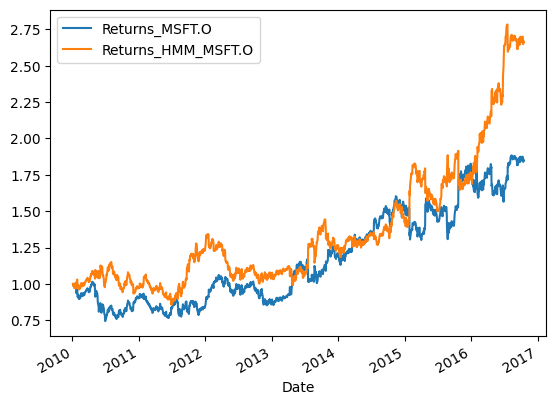

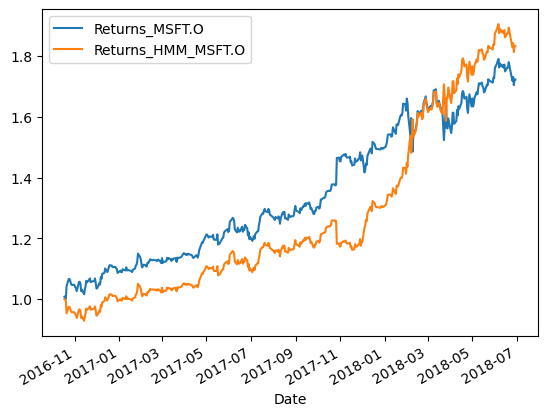

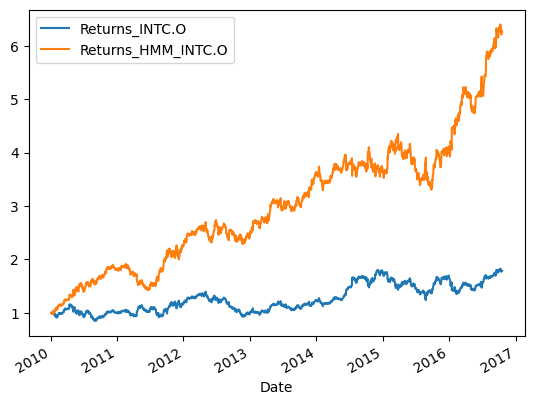

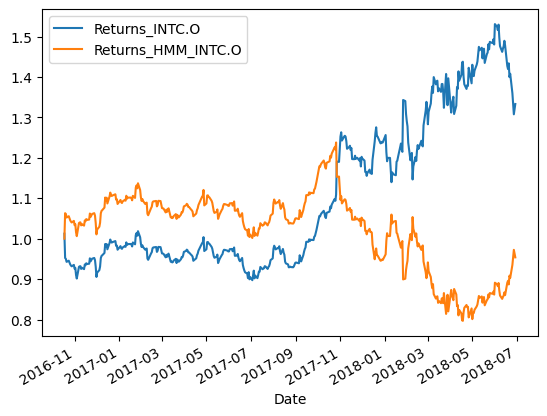

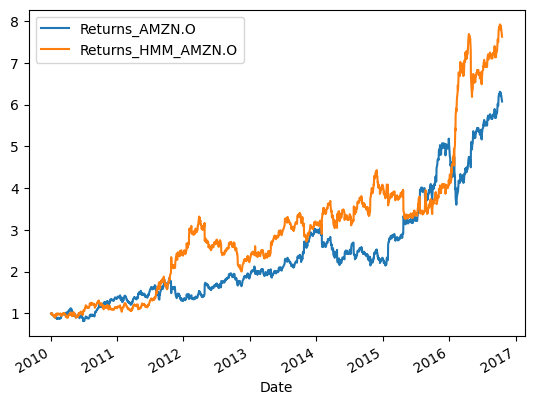

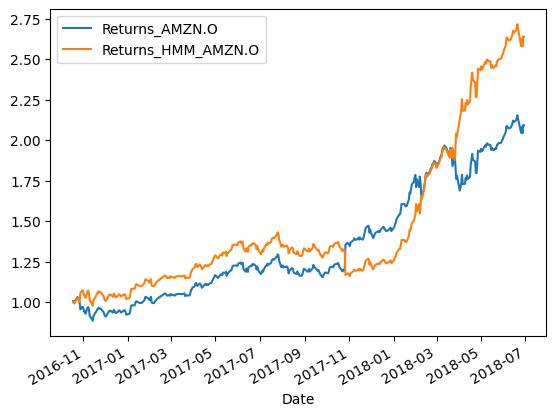

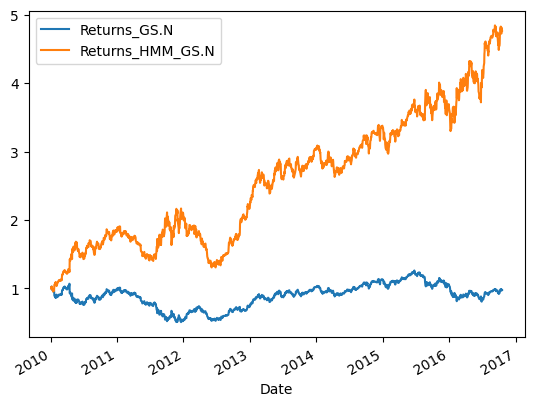

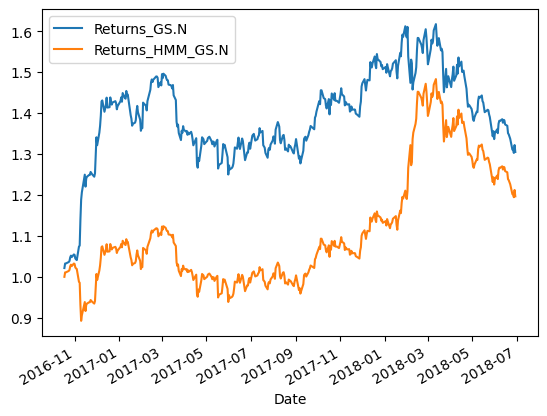

In [11]:
# print the results
# for each stock, we train the model on the training data, generate trading signals, and calculate the returns
# we then test the model on the testing data, generate trading signals, and calculate the returns
for stock in selected:
    print('--Training--')
    rets_train = data_train[['Returns_' + stock]]
    model = train_hmm(rets_train)
    hidden_states_train = model.predict(rets_train)
    trading_signals_train = generate_trading_signals(hidden_states_train, model)
    data_train['Signal_' + stock] = trading_signals_train
    data_train['Returns_HMM_' + stock] = data_train['Signal_' + stock] * data_train['Returns_' + stock]
    print(data_train[['Returns_' + stock, 'Returns_HMM_' + stock]].sum().apply(np.exp))
    data_train[['Returns_' + stock, 'Returns_HMM_' + stock]].cumsum().apply(np.exp).plot()

    print('--Testing--')
    rets_test = data_test[['Returns_' + stock]]
    hidden_states_test = model.predict(rets_test)
    trading_signals_test = generate_trading_signals(hidden_states_test, model)
    data_test['Signal_' + stock] = trading_signals_test
    data_test['Returns_HMM_' + stock] = data_test['Signal_' + stock] * data_test['Returns_' + stock]
    print(data_test[['Returns_' + stock, 'Returns_HMM_' + stock]].sum().apply(np.exp))
    data_test[['Returns_' + stock, 'Returns_HMM_' + stock]].cumsum().apply(np.exp).plot()

In [12]:
print('--Training--')
for stock in selected:
    print(data_train[['Returns_' + stock, 'Returns_HMM_' + stock]].sum().apply(np.exp))  

--Training--
Returns_AAPL.O         3.844918
Returns_HMM_AAPL.O    14.101106
dtype: float64
Returns_MSFT.O        1.848788
Returns_HMM_MSFT.O    2.662761
dtype: float64
Returns_INTC.O        1.785920
Returns_HMM_INTC.O    6.261909
dtype: float64
Returns_AMZN.O        6.071322
Returns_HMM_AMZN.O    7.624140
dtype: float64
Returns_GS.N        0.976427
Returns_HMM_GS.N    4.767952
dtype: float64


In [13]:
print('--Testing--')
for stock in selected:
    print(data_test[['Returns_' + stock, 'Returns_HMM_' + stock]].sum().apply(np.exp))

--Testing--
Returns_AAPL.O        1.574734
Returns_HMM_AAPL.O    1.517062
dtype: float64
Returns_MSFT.O        1.723348
Returns_HMM_MSFT.O    1.833671
dtype: float64
Returns_INTC.O        1.333065
Returns_HMM_INTC.O    0.953764
dtype: float64
Returns_AMZN.O        2.090903
Returns_HMM_AMZN.O    2.637601
dtype: float64
Returns_GS.N        1.305148
Returns_HMM_GS.N    1.196733
dtype: float64


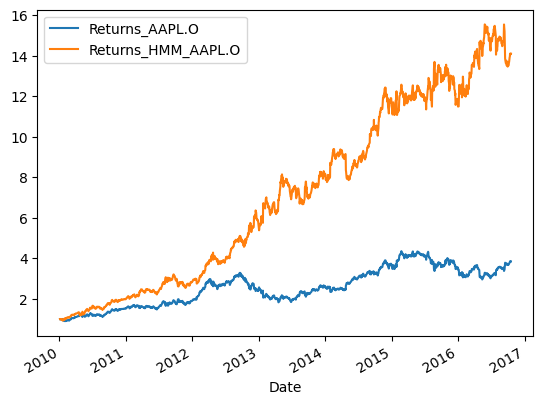

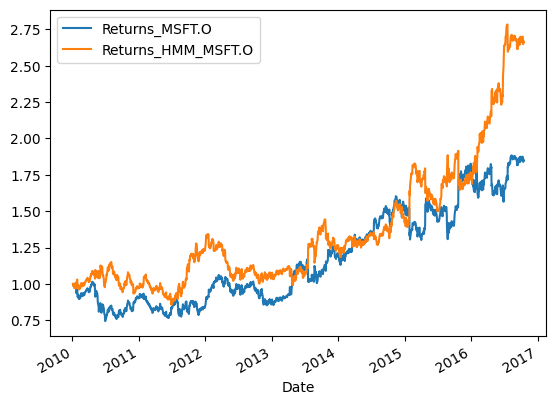

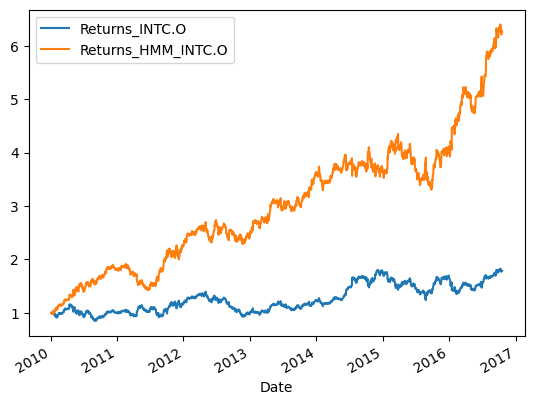

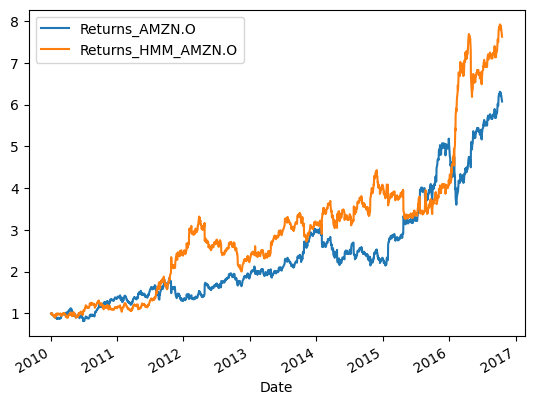

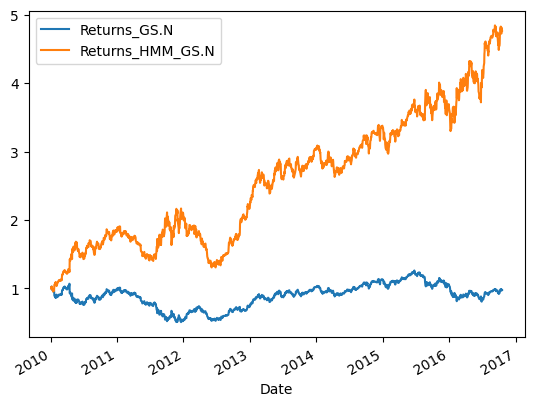

In [14]:
for stock in selected:
    data_train[['Returns_' + stock, 'Returns_HMM_' + stock]].cumsum().apply(np.exp).plot()

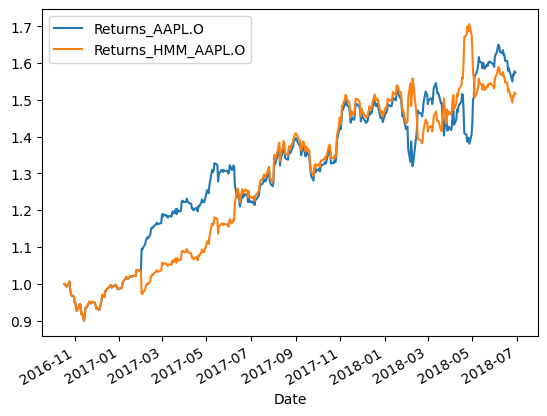

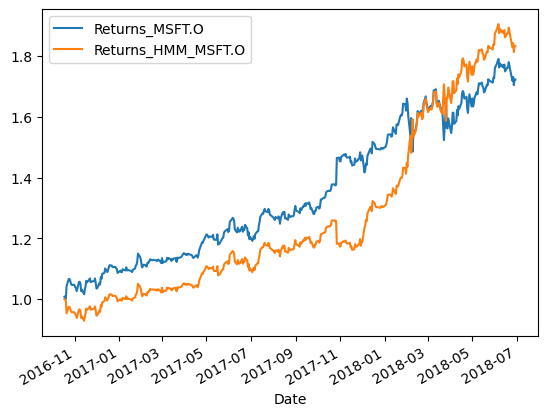

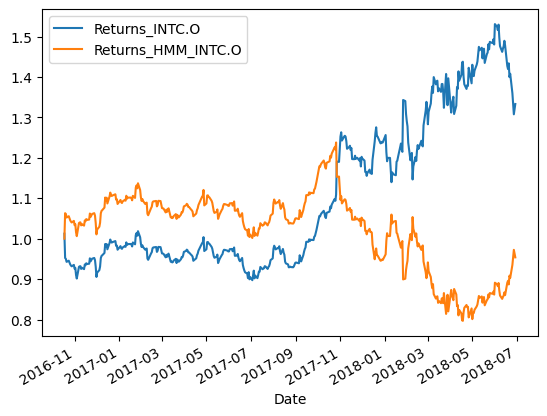

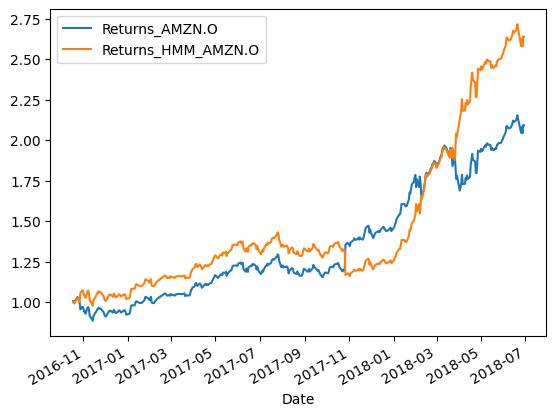

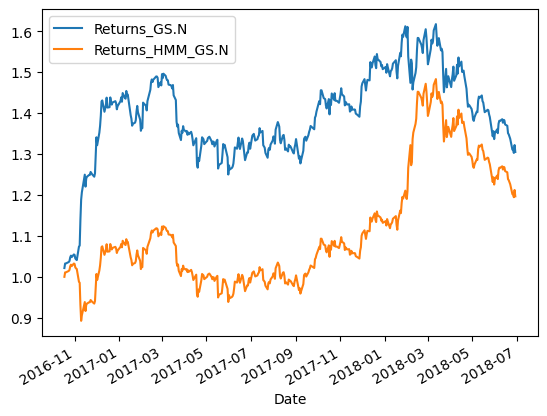

In [15]:
for stock in selected:
    data_test[['Returns_' + stock, 'Returns_HMM_' + stock]].cumsum().apply(np.exp).plot()